# **Iterations**

I think that the resolution of clustering is too high. Too many clusters are formed and the p140 expressing cells are too spread, masking their expression id the differential expression analusis

iterations for deciding 
* number of dimensions, most likely 30
* resolutions in clustering

## Files
* UMAP
* de.genes
* violin for clusters
* comparison
* Rmd

## Load Libraries

In [1]:
install.packages("tictoc") # Run only once
library(tictoc)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [4]:
# LOAD LIBRARIES
library(Seurat)
library(tidyverse)
library(future)
library(ggplot2)
library(dplyr)
library(presto)
library(cowplot)
library(tictoc)

library(enrichR)
library(org.Hs.eg.db)
library(AnnotationDbi)

library(SingleR)

library(GPTCelltype)
library(openai)


## Setup

In [2]:
# SET UP NAMES
timepoints <- c("23days", "1month", "1.5month", "2month", "3month", "4month", "5month", "6month")
housekeeping_genes <- c("ACTB", "DLG4")
genes_of_interest <- c("SRCIN1", "KIAA1217", "CIT")
path_to_data <- "/sharedFolder/Data/"

name_new_dir_results <- paste(getwd(), "/Results", sep = "")
if (!dir.exists(name_new_dir_results)) {
    dir.create(name_new_dir_results)
}

name_new_dir_partial <- paste(getwd(), "/Partial", sep = "")
if (!dir.exists(name_new_dir_partial)) {
    dir.create(name_new_dir_partial)
}

In [4]:
cores.ram <- function(cores,ram) {
  plan("multisession", workers = cores)
  options(future.globals.maxSize = ram * 1024^3)
}

In [ ]:
total_time <- function(seconds) {
    d <- seconds %/% (86400)
    h <- (seconds %% 86400) %/% 3600
    m <- (seconds %% 3600) %/% 60
    s <- seconds %% 60
    
    cat(sprintf("Total Time: %d Days, %d Hours, %d Minutes and %d Seconds\n", d, h, m, s))
}

## Functions

### load.data(time_point)
* LOAD DATA
* NORMALIZE
* FIND VARIABLE FEATURES
* SCALE DATA

In [21]:
load.data <- function(
    file_name,
    data_path = path_to_data,
    output = F,
    reduced.output = T 
) {
    if (output | reduced.output) {
        print(paste("Loading data for time point:", file_name))
    }

    # Load the data
    sc_data <- Read10X(data.dir = paste(data_path, "expression_", file_name, sep = ""), gene.column = 1)

    # Create Seurat object
    sc_data <- CreateSeuratObject(counts = sc_data, min.cells = 3, min.features = 500, project = file_name, names.delim = "-", names.field = 2)

    # Normalize the data
    sc_data <- NormalizeData(sc_data, normalization.method = "LogNormalize", scale.factor = 1e6, verbose = output)

    # Find variable features
    sc_data <- FindVariableFeatures(sc_data, selection.method = "mvp", nfeatures = 2000, verbose = output)

    # Scale the data
    sc_data <- ScaleData(sc_data, verbose = output)

    return(sc_data)
}

### PCA.cluster(data = sc_data, res)
* Run PCA
* Cluster the cells

In [7]:
PCA.cluster <- function(
    data = sc_data_scaled, 
    file_name = timepoints[time_point], 
    res = 1, 
    n_dim = 40, 
    save = F,
    output = F,
    reduced.output = T    
) {  
    if (output | reduced.output) {
        print(paste("Running PCA and clustering for time point:", file_name))
        print(paste("- Resolution:", res))
        print(paste("- Dimensions:", n_dim))
    }
        
    # PCA
    data <- RunPCA(data, npcs = n_dim, verbose = output)
    #print(ElbowPlot(object = data, ndims = 50))

    # Cluster the cells
    data <- FindNeighbors(data, dims = 1:n_dim, verbose = output)
    data <- FindClusters(data, resolution = res, verbose = output)
    
    #print(table(Idents(data)))

    # Save the PCA plot
    if (save) {
        name_new_dir <- paste(name_new_dir_partial, "/", file_name, "/cluster", param, sep="")
        if (!dir.exists(name_new_dir)) {dir.create(name_new_dir)} 
    
        print(paste("Saving PCA for time point", file_name, "in", name_new_dir))
        save(data, file = paste(name_new_dir, "/PCA_res_", res, "_dim_", n_dim, "_", file_name, ".Robj", sep=""))
    }
    return(data)
}

## UMAP

In [8]:
UMAP.plot <- function(
    data = sc_data,
    file_name = timepoints[time_point],
    n_dim = 40,
    output = F,
    reduced.output = T,
    print_plot = F
) {
    if (output | reduced.output) {
        print("Making UMAP")
    }
    
    sc_data_UMAP <- RunUMAP(data, dims = 1:n_dim, verbose = output)
    
    # Visualization of clusters   
    plot <- DimPlot(sc_data_UMAP, reduction = "umap", label = TRUE, pt.size = 1) + 
        ggtitle(paste("UMAP of Clusters -",file_name, "-", gsub("_", " ", param)))

    if (print_plot) {print(plot)}
    
    return(plot)
}

### cluster.markers(x = sc_data)
* find all markers for every cluster compared to all remaining cells

In [9]:
# FIND ALL MARKERS
cluster.markers <- function(
    data, 
    file_name = timepoints[time_point],
    output = F,
    reduced.output = T
) {
    if (output | reduced.output) {
        print(paste("Finding all markers for time point:", file_name))
    }

    # Find all markers for every cluster compared to all remaining cells
    markers <- FindAllMarkers(data,
                              only.pos = TRUE,   # Considera solo i marker espressi positivamente
                              min.pct = 0.25,    # Percentuale minima di espressione nelle cellule del cluster
                              logfc.threshold = 0.25,  # Soglia minima di LogFC
                              verbose = output)
        
    return(markers)
}

### annotation.enrichR()
* cell annotation with enrichR

In [10]:
annotation.enrichR <- function (
    top_genes,
    database = "Allen_Brain_Atlas_10x_scRNA_2021",
    output = F,
    reduced.output = T
) {
    gene_symbols <- top_genes$gene
    entrez_ids <- suppressMessages(
        mapIds(org.Hs.eg.db, keys = gene_symbols, column = "ENTREZID", keytype = "SYMBOL", multiVals = "first")
    )
    # Add Entrez IDs to your data.frame
    top_genes$entrez <- entrez_ids
    # Remove rows with NA Entrez IDs
    top_genes <- top_genes[!is.na(top_genes$entrez), ]

    annotation_list <- list()
    
    for (cl in unique(top_genes$cluster)) {
        genes_cluster <- top_genes %>% filter(cluster == cl) %>% pull(entrez)
        # Optionally, use Entrez IDs instead:
        # genes_cluster <- top_genes %>% filter(cluster == cl) %>% pull(entrez)
        
        # Perform enrichment analysis
        enriched <- enrichr(genes_cluster, databases = "Allen_Brain_Atlas_10x_scRNA_2021")

        annotation <- enriched$Allen_Brain_Atlas_10x_scRNA_2021 %>% as.data.table()
        annotation$cluster <- as.numeric(cl)

        annotation_list[[cl]] <- allen[grepl("Human", allen$Term, ignore.case = TRUE) & allen$Adjusted.P.value < 5e-2]
    }


    return(annotation_list)
}

## Prove

In [66]:
sc_data <- load.data("23days")

[1] "Loading data for time point: 23days"


In [67]:
sc_data <- PCA.cluster(x = sc_data, file_name = "23days")

[1] "Running PCA and clustering for time point: 23days"
[1] "- Resolution: 1"
[1] "- Dimensions: 40"

   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
5195 2314 2018 2001 1731 1659 1558 1476 1446 1341 1213 1185 1021  914  872  585 
  16   17   18   19   20   21   22   23   24 
 578  545  526  488  401  362  116  106   85 


In [22]:
sc_data_pca <- RunPCA(sc_data, npcs = 50, verbose = F)

In [46]:
sc_cl <- FindNeighbors(sc_data_pca, dims = 1:40, verbose = FALSE)
sc_cl <- FindClusters(sc_cl, resolution = 0.1, verbose = FALSE)

In [55]:
head(a)

,orig.ident,nCount_RNA,nFeature_RNA,RNA_snn_res.1,seurat_clusters
,<fct>,<dbl>,<int>,<fct>,<fct>
1_AAACGAACACGTGAGA-1_1_23d,1_1_23d,3724,536,5,5
1_AAACGAAGTCGAAACG-1_1_23d,1_1_23d,9184,2310,5,5
1_AAACGAAGTGGCAGAT-1_1_23d,1_1_23d,6357,2068,19,19
1_AAACGAAGTGGTTCTA-1_1_23d,1_1_23d,3468,1292,17,17
1_AAACGAAGTTGGCCGT-1_1_23d,1_1_23d,1809,832,19,19
1_AAACGAATCCTTCACG-1_1_23d,1_1_23d,7587,1985,5,5
1_AAACGCTCAAGCGGAT-1_1_23d,1_1_23d,5924,1600,9,9
1_AAACGCTCACTTCAAG-1_1_23d,1_1_23d,2264,1110,3,3
1_AAACGCTCATCATCCC-1_1_23d,1_1_23d,9277,2441,19,19


In [61]:
# Replace 'obj1' and 'obj2' with your Seurat object names
# Replace 'cluster_x' and 'cluster_y' with your actual cluster identifiers (numbers or names)

# Get cell names for each cluster
cells_in_a <- WhichCells(a, idents = "23")
cells_in_sc_cl <- WhichCells(sc_cl, idents = "7")

# Calculate intersection and percentages
intersection <- intersect(cells_in_a, cells_in_sc_cl)
n_common <- length(intersection)

percent_in_a <- n_common / length(cells_in_a) * 100
percent_in_sc_cl <- n_common / length(cells_in_sc_cl) * 100

cat(sprintf("Percentage of cells from obj1 cluster in common: %.1f%%\n", percent_in_a))
cat(sprintf("Percentage of cells from obj2 cluster in common: %.1f%%\n", percent_in_sc_cl))

Percentage of cells from obj1 cluster in common: 0.0%
Percentage of cells from obj2 cluster in common: 0.0%


In [62]:
a <- table(Idents(sc_cl))
a


   0    1    2    3    4    5    6    7    8 
9517 6143 4993 3100 2637 2123 1022  116   85 

In [64]:
a

ERROR: Error in parse(text = x, srcfile = src): <text>:1:3: unexpected numeric constant
1: a$0
      ^


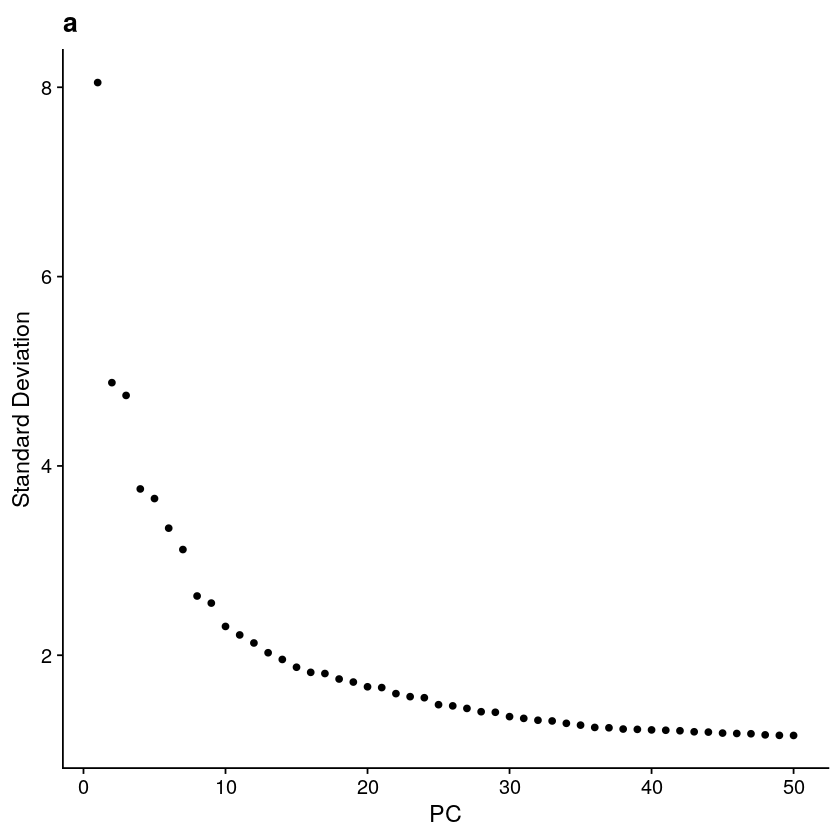

In [27]:
a <- ElbowPlot(object = sc_data_pca, ndims = 50) + labs(title = "a")
a

In [26]:
ggsave("a.png", plot=a)

Saving 6.67 x 6.67 in image


In [18]:
stddev <- sc_data_pca[["pca"]]@stdev

In [21]:
stddev

[1] 8.049796 4.879654 4.744687 3.756872 3.655245 3.342558 3.116703 2.625784
 [9] 2.551026 2.304381 2.214553 2.129654 2.026551 1.955606 1.873429 1.819461
[17] 1.806962 1.748940 1.716884 1.666950 1.658559 1.594699 1.562629 1.551379
[25] 1.477870 1.465293 1.438353 1.403470 1.397773 1.351655 1.333203 1.313543
[33] 1.305862 1.280887 1.261786 1.237566 1.233717 1.220439 1.217101 1.211383
[41] 1.207841 1.202422 1.191543 1.188108 1.177787 1.173605 1.170669 1.158945
[49] 1.153813 1.152698

In [23]:
for (i in 2:50) {
    print(paste(i-1, "- % difference between", i-1, "and", i, "dimensions:", stddev[i]/stddev[i-1]*100))
}

[1] "1 - % difference between 1 and 2 dimensions: 60.6183557250521"
[1] "2 - % difference between 2 and 3 dimensions: 97.2340784986035"
[1] "3 - % difference between 3 and 4 dimensions: 79.1806055362017"
[1] "4 - % difference between 4 and 5 dimensions: 97.2949084180213"
[1] "5 - % difference between 5 and 6 dimensions: 91.4455343942791"
[1] "6 - % difference between 6 and 7 dimensions: 93.2430557153058"
[1] "7 - % difference between 7 and 8 dimensions: 84.2487533461944"
[1] "8 - % difference between 8 and 9 dimensions: 97.152926164552"
[1] "9 - % difference between 9 and 10 dimensions: 90.3315545207316"
[1] "10 - % difference between 10 and 11 dimensions: 96.1018474608301"
[1] "11 - % difference between 11 and 12 dimensions: 96.1663316583113"
[1] "12 - % difference between 12 and 13 dimensions: 95.1586915499239"
[1] "13 - % difference between 13 and 14 dimensions: 96.4992281092811"
[1] "14 - % difference between 14 and 15 dimensions: 95.7978688180613"
[1] "15 - % difference between 15

## Do

In [29]:
dir_results <- paste0("Results/Iterations")     
if (!dir.exists(dir_results)) {
    dir.create(dir_results)
}

In [8]:
library(tictoc)
timings <- data.frame(Function=character(), Time=numeric())

In [23]:
f_name <- "23days"
clustering_resolution <- 0.5
n_of_dimesnions <- 30

char_res <- as.character(clustering_resolution)
if (grepl("\\.", char_res)) {char_res <- gsub("\\.", "_", char_res)}
param <- paste0("_res_", char_res, "_dim_", n_of_dimesnions)

In [24]:
tic()
# Load data
sc_data_scaled <- load.data(file_name = f_name)

toc()

[1] "Loading data for time point: 23days"
make umap: 20.85 sec elapsed


In [155]:
new_dir <- paste(dir_results, "/", f_name, param, sep="")     
if (!dir.exists(new_dir)) {
    dir.create(new_dir)
    print("Directory created")
} else {
    print("Directory already exists")
}

[1] "Directory already exists"


In [25]:
tic()
# Clusterize
sc_data <- PCA.cluster(data = sc_data_scaled, file_name = f_name, 
                       res = clustering_resolution, 
                       n_dim = n_of_dimesnions)
toc()

[1] "Running PCA and clustering for time point: 23days"
[1] "- Resolution: 0.5"
[1] "- Dimensions: 30"
make umap: 13.002 sec elapsed


In [26]:
# indents?
print(table(Idents(sc_data)))


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
7219 2595 2525 2256 2209 2133 2082 1813 1812 1788 1142 1020  524  417  116   85 


[1] "Making UMAP"
make umap: 17.862 sec elapsed
save: 0.822 sec elapsed


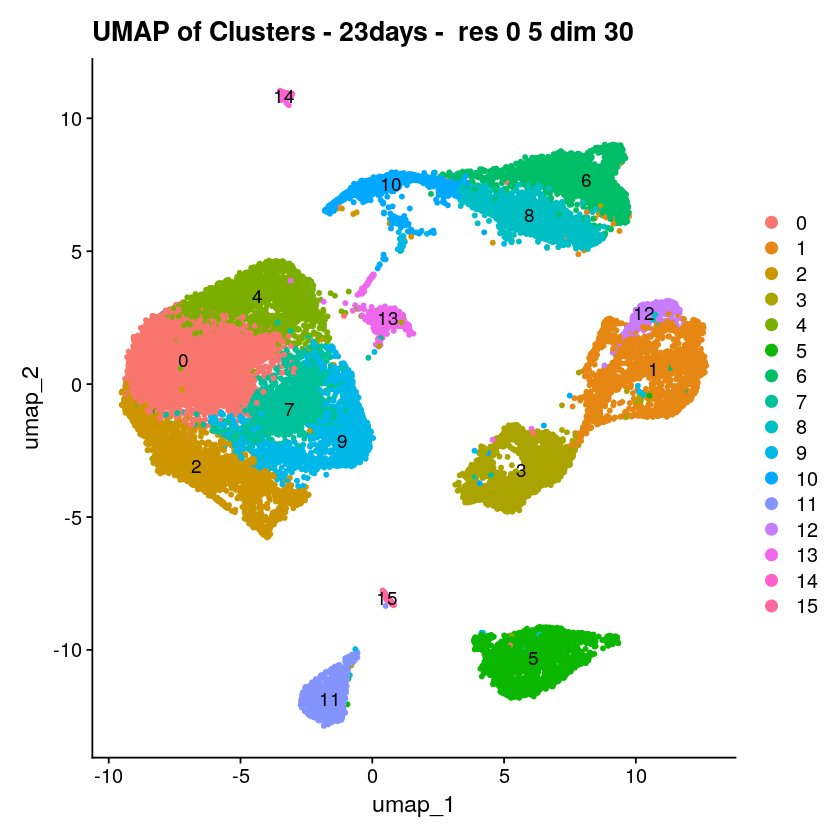

In [27]:
tic("make umap")
# UMAP
plot_UMAP <- UMAP.plot(data = sc_data, 
                       file_name = "23days", 
                       n_dim = n_of_dimesnions, 
                       print_plot = T)
toc()
tic("save")
ggsave(
    paste0(
        new_dir, "/",
        "UMAP",
        f_name,
        param,
        ".png"
    ), 
    plot=plot_UMAP, 
    width = 1920*2, height = 1980*2, units = "px"
)

toc()

In [28]:
tic()
# Find Markers
cluster_markers <- cluster.markers(data = sc_data, file_name = f_name, output = T)
toc()

[1] "Finding all markers for time point: 23days"


Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15



47.947 sec elapsed


In [21]:
# Annotation - enrichR


## For

In [ ]:
execute.job <- function(
    f_name,
    clustering_resolution,
    n_of_dimesnions
) {
    char_res <- as.character(clustering_resolution)
    if (grepl("\\.", char_res)) {char_res <- gsub("\\.", "_", char_res)}
    param <- paste0("_res_", char_res, "_dim_", n_of_dimesnions)
    
    new_dir <- paste(dir_results, "/", f_name, param, sep="")     
    if (!dir.exists(new_dir)) {
        dir.create(new_dir)
    }
    
    # Load data
    sc_data <- load.data(file_name = f_name)

    # Clusterize
    sc_data <- PCA.cluster(data = sc_data, file_name = f_name, 
                           res = clustering_resolution, 
                           n_dim = n_of_dimesnions)

    # indents?

    # UMAP
    plot_UMAP <- UMAP.plot(data = sc_data, file_name = "23days")
    ggsave(
        paste0(
            new_dir, "/",
            "UMAP",
            f_name,
            param,
            ".png"
        ), 
        plot=plot_UMAP, 
        width = 1920*2, height = 1980*2, units = "px"
    )

    # Find Markers
    cluster_markers <- cluster.markers(data = sc_data, file_name = f_name)

    # Annotation
}

In [7]:
res_list <- seq(0.1, 1, by = 0.1)
dim_list <- c(20, 30, 40, 50)

cycles_per_timepoint <- length(res_list)*length(dim_list)
print(paste("Number of cycles per timepoint:", cycles_per_timepoint))
tot_cycles <- cycles_per_timepoint*length(timepoints)
print(paste("Total number of cycles:", tot_cycles))

a<- paste0("res_", res_list, "_dim_")
cycle_list <- c()
for (i in dim_list) {
    cycle_list <- c(cycle_list, paste0(a, dim_list))
}

[1] "Number of cycles per timepoint: 40"
[1] "Total number of cycles: 320"


In [15]:
cycle_list

[1] "res_0.1_dim_20" "res_0.2_dim_30" "res_0.3_dim_40" "res_0.4_dim_50"
 [5] "res_0.5_dim_20" "res_0.6_dim_30" "res_0.7_dim_40" "res_0.8_dim_50"
 [9] "res_0.9_dim_20" "res_1_dim_30"   "res_0.1_dim_20" "res_0.2_dim_30"
[13] "res_0.3_dim_40" "res_0.4_dim_50" "res_0.5_dim_20" "res_0.6_dim_30"
[17] "res_0.7_dim_40" "res_0.8_dim_50" "res_0.9_dim_20" "res_1_dim_30"  
[21] "res_0.1_dim_20" "res_0.2_dim_30" "res_0.3_dim_40" "res_0.4_dim_50"
[25] "res_0.5_dim_20" "res_0.6_dim_30" "res_0.7_dim_40" "res_0.8_dim_50"
[29] "res_0.9_dim_20" "res_1_dim_30"   "res_0.1_dim_20" "res_0.2_dim_30"
[33] "res_0.3_dim_40" "res_0.4_dim_50" "res_0.5_dim_20" "res_0.6_dim_30"
[37] "res_0.7_dim_40" "res_0.8_dim_50" "res_0.9_dim_20" "res_1_dim_30"

In [6]:
which(res_list == 0.2)

[1] 2

In [63]:
timings <- as.data.frame(matrix(
    ncol = cycles_per_timepoint, 
    nrow = length(timepoints),
))
rownames(timings) <- timepoints
colnames(timings) <- cycle_list
timings

,res_0.1_dim_20,res_0.2_dim_30,res_0.3_dim_40,res_0.4_dim_50,res_0.5_dim_20,res_0.6_dim_30,res_0.7_dim_40,res_0.8_dim_50,res_0.9_dim_20,res_1_dim_30,⋯,res_0.1_dim_20,res_0.2_dim_30,res_0.3_dim_40,res_0.4_dim_50,res_0.5_dim_20,res_0.6_dim_30,res_0.7_dim_40,res_0.8_dim_50,res_0.9_dim_20,res_1_dim_30
,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
23days,1,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1month,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1.5month,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2month,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3month,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4month,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5month,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6month,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [66]:
timings["23days", "res_0.1_dim_20"]

[1] 1

In [22]:
iterations <- function(
    timepoints = c("23days", "1month", "1.5month", "2month", "3month", "4month", "5month", "6month"),
    housekeeping_genes = c("ACTB", "DLG4"),
    genes_of_interest = c("SRCIN1", "KIAA1217", "CIT"),
    path_to_data = "/sharedFolder/Data/",
    res_list = seq(0.1, 1, by = 0.1),
    dim_list = c(20, 30, 40, 50),
    top_n_genes = 50,
    check_for_saved_plot = F,
    output = F,
    reduced.output = T,
    print.plot = F
) {
    print(paste("Path to data:", path_to_data))
    print(paste("Timepoints:", timepoints))
    print(paste("Housekeeping genes:", housekeeping_genes))
    print(paste("Genes of interest:", genes_of_interest))
    print("")

    print(paste("Resolutions:", res_list))
    print(paste("Number of dimension:", dim_list))
    print("")
    
    # Total number of 
    cycles_per_timepoint <- length(res_list)*length(dim_list)
    print(paste("Number of cycles per timepoint:", cycles_per_timepoint))
    tot_cycles <- cycles_per_timepoint*length(timepoints)
    print(paste("Total number of cycles:", tot_cycles))
    print("")
    
    N_cycle <- 0
    
    dir_iterations <- paste0("Results/Iterations")     
    if (!dir.exists(dir_iterations)) {dir.create(dir_iterations)}
    
    print("Starting")
    
    timings <- data.frame()
    n_of_clusters <- data.frame()
    
    tic("Iterations")
    
    for (f_name in timepoints) {
        tic(paste("Loading", f_name))
    
        dir_timepoint <- paste(dir_iterations, "/", f_name, sep="")     
        if (!dir.exists(dir_timepoint)) {dir.create(dir_timepoint)}
        
        # Load data
        sc_data_scaled <- load.data(file_name = f_name, data_path = path_to_data, output = output, reduced.output = reduced.output)
    
        toc(quiet = T)
    
        for (clustering_resolution in res_list) {
            for (n_of_dimesnions in dim_list) {
                # Progression Message
                N_cycle <- N_cycle + 1
                print(paste(N_cycle, "of", tot_cycles)) 
                print(paste(f_name, "- Res:", clustering_resolution, "- Dim:", n_of_dimesnions))
    
                # param
                char_res <- as.character(clustering_resolution)
                if (grepl("\\.", char_res)) {char_res <- gsub("\\.", "_", char_res)}
                param <- paste0("_res_", char_res, "_dim_", n_of_dimesnions)
    
                # Create subfolder
                new_dir <- paste(dir_timepoint, "/", f_name, param, sep="")     
                if (!dir.exists(new_dir)) {dir.create(new_dir)}
    
                # start time
                tic(paste(f_name, "- Res:", clustering_resolution, "- Dim:", n_of_dimesnions))
    
                # Clusterize
                sc_data <- PCA.cluster(
                    data = sc_data_scaled, 
                    file_name = f_name, 
                    res = clustering_resolution, 
                    n_dim = n_of_dimesnions,
                    output = output, 
                    reduced.output = reduced.output
                )
    
                n_of_clusters[paste0("res_", clustering_resolution, "_dim_", n_of_dimesnions), f_name] <- length(table(Idents(sc_data)))
    
                # UMAP
                plot_UMAP <- UMAP.plot(
                    data = sc_data, 
                    file_name = "23days", 
                    n_dim = n_of_dimesnions, 
                    output = output, 
                    reduced.output = reduced.output,
                    print_plot = print.plot
                )

                # Save UMAP
                umap_file_name <- paste0(new_dir, "/UMAP",f_name,param,".png")
                if (!(check_for_saved_plot & exists(umap_file_name))) {
                    ggsave(
                        umap_file_name, 
                        plot=plot_UMAP, 
                        width = 1920*2, height = 1980*2, units = "px"
                    )
                }
    
                # Find Markers
                cluster_markers <- cluster.markers(
                    data = sc_data, 
                    file_name = f_name, 
                    output = output, 
                    reduced.output = reduced.output
                )
    
                write.csv(cluster_markers, file = paste0(
                    new_dir, "/",
                    "cluster_markers_",
                    f_name,
                    param,
                    ".csv"
                ))

                # Top top_n_genes DE genes
                top_genes_by_cluster <- cluster_markers %>% group_by(cluster) %>% top_n(n = top_n_genes, wt = avg_log2FC) %>% as.data.frame()

                write.csv(top_genes_by_cluster, file = paste0(
                    new_dir, "/",
                    "top_genes_by_cluster_",
                    f_name,
                    param,
                    ".csv"
                ))
    
                # Annotation - enrichR
                enrichR_list <- annotation.enrichR(
                    top_genes = top_genes_by_cluster,
                    database = "Allen_Brain_Atlas_10x_scRNA_2021"
                )

                write.csv(bind_rows(enrichR_list), file = paste0(
                    new_dir, "/",
                    "enrichR_annotation_",
                    f_name,
                    param,
                    ".csv"
                ), row.names = FALSE)
    
                # Annotation - singelR
    
                # Annotation - CPTCellType
    
                # end time
                elapsed <- toc(log = TRUE, quiet = T)
                timings[f_name, paste0("res_", clustering_resolution, "_dim_", n_of_dimesnions)] <- elapsed$toc - elapsed$tic
            }
        }

        print("") # an empti line for better visualization 
    }

    timings$tot_time <- rowSums(timings)

    write.csv(timings, file = paste0(dir_iterations, "/tmings.csv"))
    
    n_tocken_gpt <- n_of_clusters*837.5
    n_tocken_gpt$total <- rowSums(n_tocken_gpt)

    write.csv(n_tocken_gpt, file = paste0(dir_iterations, "/number_of_tokens.csv"))
    
    tot_elapsed <- toc(log = TRUE, quiet = F)
    print("END")
    return(list(timings, n_of_clusters))
}

In [23]:
# LOAD LIBRARIES
library(Seurat)
library(tidyverse)
library(future)
library(ggplot2)
library(dplyr)
library(presto)
library(cowplot)
library(tictoc)

library(enrichR)
library(org.Hs.eg.db)
library(AnnotationDbi)

library(SingleR)

library(GPTCelltype)
library(openai)

In [24]:
tic("Iterations")
iterations <- capture.output(
    iterations(
        timepoints = c("23days", "1month", "1.5month", "2month", "3month", "4month", "5month", "6month"),
        housekeeping_genes = c("ACTB", "DLG4"),
        genes_of_interest = c("SRCIN1", "KIAA1217", "CIT"),
        path_to_data = "/sharedFolder/Data/",
        res_list = seq(0.1, 1, by = 0.1),
        dim_list = c(20, 30, 40, 50),
        top_n_genes = 50,
        check_for_saved_plot = T,
        output = F, 
        reduced.output = T, 
        print.plot = F
    ),
    file = "/sharedFolder/Paper_clusters_from_scratch/Results/Iterations/0_output.pdf"
)
elapsed <- toc(log = TRUE, quiet = T)
total_time(elapsed$toc - elapsed$tic)

print(iterations)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’



ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'gsub': object 'param' not found


In [8]:
N_cycle <- 0

dir_iterations <- paste0("Results/Iterations")     
if (!dir.exists(dir_iterations)) {dir.create(dir_iterations)}

print("Starting")

timings <- data.frame()
n_of_clusters <- data.frame()

tic("Iterations")

for (f_name in timepoints) {
    tic(paste("Loading", f_name))

    dir_timepoint <- paste(dir_iterations, "/", f_name, sep="")     
    if (!dir.exists(dir_timepoint)) {dir.create(dir_timepoint)}
    
    # Load data
    sc_data_scaled <- load.data(file_name = f_name, reduced.output = F)

    toc(quiet = T)

    for (clustering_resolution in res_list) {
        for (n_of_dimesnions in dim_list) {
            # Progression Message
            N_cycle <- N_cycle + 1
            print(paste(N_cycle, "of", tot_cycles)) 
            print(paste(f_name, "- Res:", clustering_resolution, "- Dim:", n_of_dimesnions))

            # param
            char_res <- as.character(clustering_resolution)
            if (grepl("\\.", char_res)) {char_res <- gsub("\\.", "_", char_res)}
            param <- paste0("_res_", char_res, "_dim_", n_of_dimesnions)

            # Create subfolder
            new_dir <- paste(dir_timepoint, "/", f_name, param, sep="")     
            if (!dir.exists(new_dir)) {dir.create(new_dir)}

            # start time
            tic(paste(f_name, "- Res:", clustering_resolution, "- Dim:", n_of_dimesnions))

            # Clusterize
            sc_data <- PCA.cluster(
                data = sc_data_scaled, 
                file_name = f_name, 
                res = clustering_resolution, 
                n_dim = n_of_dimesnions,
                reduced.output = F
            )

            n_of_clusters[f_name, paste0("res_", clustering_resolution, "_dim_", n_of_dimesnions)] <- length(table(Idents(sc_data)))

            # UMAP
            plot_UMAP <- UMAP.plot(
                data = sc_data, 
                file_name = "23days", 
                n_dim = n_of_dimesnions, 
                print_plot = F,
                reduced.output = F
            )
            ggsave(
                paste0(
                    new_dir, "/",
                    "UMAP",
                    f_name,
                    param,
                    ".png"
                ), 
                plot=plot_UMAP, 
                width = 1920*2, height = 1980*2, units = "px"
            )

            # Find Markers
            cluster_markers <- cluster.markers(data = sc_data, file_name = f_name, output = F, reduced.output = F)

            write.csv(cluster_markers, file = paste0(
                new_dir, "/",
                "cluster_markers_",
                f_name,
                param,
                ".csv"
            ))

            # Annotation - enrichR

            # Annotation - singelR

            # Annotation - CPTCellType

            # end time
            elapsed <- toc(log = TRUE, quiet = T)
            timings[f_name, paste0("res_", clustering_resolution, "_dim_", n_of_dimesnions)] <- elapsed$toc - elapsed$tic
        }
    }
}

tot_elapsed <- toc(log = TRUE, quiet = F)
print("END")
print(timings)

[1] "Starting"
[1] "Loading data for time point: 23days"
Loading 23days: 24.777 sec elapsed
[1] "1 of 320"
[1] "23days - Res: 0.1 - Dim: 20"
[1] "Running PCA and clustering for time point: 23days"
[1] "- Resolution: 0.1"
[1] "- Dimensions: 20"
[1] "Making UMAP"


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


23days - Res: 0.1 - Dim: 20: 30.887 sec elapsed
[1] "2 of 320"
[1] "23days - Res: 0.1 - Dim: 30"
[1] "Running PCA and clustering for time point: 23days"
[1] "- Resolution: 0.1"
[1] "- Dimensions: 30"
[1] "Making UMAP"
23days - Res: 0.1 - Dim: 30: 30.196 sec elapsed
[1] "3 of 320"
[1] "23days - Res: 0.1 - Dim: 40"
[1] "Running PCA and clustering for time point: 23days"
[1] "- Resolution: 0.1"
[1] "- Dimensions: 40"
[1] "Making UMAP"
23days - Res: 0.1 - Dim: 40: 32.624 sec elapsed
[1] "4 of 320"
[1] "23days - Res: 0.1 - Dim: 50"
[1] "Running PCA and clustering for time point: 23days"
[1] "- Resolution: 0.1"
[1] "- Dimensions: 50"
[1] "Making UMAP"
23days - Res: 0.1 - Dim: 50: 34.298 sec elapsed
[1] "5 of 320"
[1] "23days - Res: 0.2 - Dim: 20"
[1] "Running PCA and clustering for time point: 23days"
[1] "- Resolution: 0.2"
[1] "- Dimensions: 20"
[1] "Making UMAP"
23days - Res: 0.2 - Dim: 20: 29.13 sec elapsed
[1] "6 of 320"
[1] "23days - Res: 0.2 - Dim: 30"
[1] "Running PCA and clustering 

Warning message:
“Input parameters result in NA values for initial cell identities. Setting all initial idents to the project name”


Loading 1month: 67.773 sec elapsed
[1] "41 of 320"
[1] "1month - Res: 0.1 - Dim: 20"
[1] "Running PCA and clustering for time point: 1month"
[1] "- Resolution: 0.1"
[1] "- Dimensions: 20"
[1] "Making UMAP"
1month - Res: 0.1 - Dim: 20: 81.035 sec elapsed
[1] "42 of 320"
[1] "1month - Res: 0.1 - Dim: 30"
[1] "Running PCA and clustering for time point: 1month"
[1] "- Resolution: 0.1"
[1] "- Dimensions: 30"
[1] "Making UMAP"
1month - Res: 0.1 - Dim: 30: 79.011 sec elapsed
[1] "43 of 320"
[1] "1month - Res: 0.1 - Dim: 40"
[1] "Running PCA and clustering for time point: 1month"
[1] "- Resolution: 0.1"
[1] "- Dimensions: 40"
[1] "Making UMAP"
1month - Res: 0.1 - Dim: 40: 83.293 sec elapsed
[1] "44 of 320"
[1] "1month - Res: 0.1 - Dim: 50"
[1] "Running PCA and clustering for time point: 1month"
[1] "- Resolution: 0.1"
[1] "- Dimensions: 50"
[1] "Making UMAP"
1month - Res: 0.1 - Dim: 50: 83.975 sec elapsed
[1] "45 of 320"
[1] "1month - Res: 0.2 - Dim: 20"
[1] "Running PCA and clustering for tim

Warning message:
“Input parameters result in NA values for initial cell identities. Setting all initial idents to the project name”


Loading 3month: 131.527 sec elapsed
[1] "161 of 320"
[1] "3month - Res: 0.1 - Dim: 20"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.1"
[1] "- Dimensions: 20"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.1 - Dim: 20: 197.591 sec elapsed
[1] "162 of 320"
[1] "3month - Res: 0.1 - Dim: 30"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.1"
[1] "- Dimensions: 30"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.1 - Dim: 30: 197.208 sec elapsed
[1] "163 of 320"
[1] "3month - Res: 0.1 - Dim: 40"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.1"
[1] "- Dimensions: 40"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.1 - Dim: 40: 202.847 sec elapsed
[1] "164 of 320"
[1] "3month - Res: 0.1 - Dim: 50"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.1"
[1] "- Dimensions: 50"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.1 - Dim: 50: 207.741 sec elapsed
[1] "165 of 320"
[1] "3month - Res: 0.2 - Dim: 20"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.2"
[1] "- Dimensions: 20"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.2 - Dim: 20: 193.655 sec elapsed
[1] "166 of 320"
[1] "3month - Res: 0.2 - Dim: 30"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.2"
[1] "- Dimensions: 30"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.2 - Dim: 30: 193.011 sec elapsed
[1] "167 of 320"
[1] "3month - Res: 0.2 - Dim: 40"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.2"
[1] "- Dimensions: 40"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.2 - Dim: 40: 201.399 sec elapsed
[1] "168 of 320"
[1] "3month - Res: 0.2 - Dim: 50"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.2"
[1] "- Dimensions: 50"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.2 - Dim: 50: 211.437 sec elapsed
[1] "169 of 320"
[1] "3month - Res: 0.3 - Dim: 20"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.3"
[1] "- Dimensions: 20"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.3 - Dim: 20: 192.489 sec elapsed
[1] "170 of 320"
[1] "3month - Res: 0.3 - Dim: 30"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.3"
[1] "- Dimensions: 30"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.3 - Dim: 30: 191.349 sec elapsed
[1] "171 of 320"
[1] "3month - Res: 0.3 - Dim: 40"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.3"
[1] "- Dimensions: 40"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.3 - Dim: 40: 199.634 sec elapsed
[1] "172 of 320"
[1] "3month - Res: 0.3 - Dim: 50"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.3"
[1] "- Dimensions: 50"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.3 - Dim: 50: 214.169 sec elapsed
[1] "173 of 320"
[1] "3month - Res: 0.4 - Dim: 20"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.4"
[1] "- Dimensions: 20"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.4 - Dim: 20: 191.667 sec elapsed
[1] "174 of 320"
[1] "3month - Res: 0.4 - Dim: 30"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.4"
[1] "- Dimensions: 30"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.4 - Dim: 30: 190.749 sec elapsed
[1] "175 of 320"
[1] "3month - Res: 0.4 - Dim: 40"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.4"
[1] "- Dimensions: 40"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.4 - Dim: 40: 206.17 sec elapsed
[1] "176 of 320"
[1] "3month - Res: 0.4 - Dim: 50"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.4"
[1] "- Dimensions: 50"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.4 - Dim: 50: 208.393 sec elapsed
[1] "177 of 320"
[1] "3month - Res: 0.5 - Dim: 20"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.5"
[1] "- Dimensions: 20"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.5 - Dim: 20: 191.762 sec elapsed
[1] "178 of 320"
[1] "3month - Res: 0.5 - Dim: 30"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.5"
[1] "- Dimensions: 30"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.5 - Dim: 30: 195.633 sec elapsed
[1] "179 of 320"
[1] "3month - Res: 0.5 - Dim: 40"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.5"
[1] "- Dimensions: 40"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.5 - Dim: 40: 206.416 sec elapsed
[1] "180 of 320"
[1] "3month - Res: 0.5 - Dim: 50"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.5"
[1] "- Dimensions: 50"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.5 - Dim: 50: 211.486 sec elapsed
[1] "181 of 320"
[1] "3month - Res: 0.6 - Dim: 20"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.6"
[1] "- Dimensions: 20"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.6 - Dim: 20: 191.432 sec elapsed
[1] "182 of 320"
[1] "3month - Res: 0.6 - Dim: 30"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.6"
[1] "- Dimensions: 30"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.6 - Dim: 30: 194.389 sec elapsed
[1] "183 of 320"
[1] "3month - Res: 0.6 - Dim: 40"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.6"
[1] "- Dimensions: 40"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.6 - Dim: 40: 202.172 sec elapsed
[1] "184 of 320"
[1] "3month - Res: 0.6 - Dim: 50"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.6"
[1] "- Dimensions: 50"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.6 - Dim: 50: 213.196 sec elapsed
[1] "185 of 320"
[1] "3month - Res: 0.7 - Dim: 20"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.7"
[1] "- Dimensions: 20"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.7 - Dim: 20: 196.238 sec elapsed
[1] "186 of 320"
[1] "3month - Res: 0.7 - Dim: 30"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.7"
[1] "- Dimensions: 30"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.7 - Dim: 30: 188.022 sec elapsed
[1] "187 of 320"
[1] "3month - Res: 0.7 - Dim: 40"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.7"
[1] "- Dimensions: 40"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.7 - Dim: 40: 202.969 sec elapsed
[1] "188 of 320"
[1] "3month - Res: 0.7 - Dim: 50"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.7"
[1] "- Dimensions: 50"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.7 - Dim: 50: 214.442 sec elapsed
[1] "189 of 320"
[1] "3month - Res: 0.8 - Dim: 20"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.8"
[1] "- Dimensions: 20"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.8 - Dim: 20: 194.812 sec elapsed
[1] "190 of 320"
[1] "3month - Res: 0.8 - Dim: 30"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.8"
[1] "- Dimensions: 30"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.8 - Dim: 30: 195.887 sec elapsed
[1] "191 of 320"
[1] "3month - Res: 0.8 - Dim: 40"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.8"
[1] "- Dimensions: 40"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.8 - Dim: 40: 200.535 sec elapsed
[1] "192 of 320"
[1] "3month - Res: 0.8 - Dim: 50"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.8"
[1] "- Dimensions: 50"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.8 - Dim: 50: 210.128 sec elapsed
[1] "193 of 320"
[1] "3month - Res: 0.9 - Dim: 20"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.9"
[1] "- Dimensions: 20"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.9 - Dim: 20: 194.773 sec elapsed
[1] "194 of 320"
[1] "3month - Res: 0.9 - Dim: 30"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.9"
[1] "- Dimensions: 30"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.9 - Dim: 30: 192.38 sec elapsed
[1] "195 of 320"
[1] "3month - Res: 0.9 - Dim: 40"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.9"
[1] "- Dimensions: 40"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.9 - Dim: 40: 203.138 sec elapsed
[1] "196 of 320"
[1] "3month - Res: 0.9 - Dim: 50"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 0.9"
[1] "- Dimensions: 50"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 0.9 - Dim: 50: 212.045 sec elapsed
[1] "197 of 320"
[1] "3month - Res: 1 - Dim: 20"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 1"
[1] "- Dimensions: 20"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 1 - Dim: 20: 194.494 sec elapsed
[1] "198 of 320"
[1] "3month - Res: 1 - Dim: 30"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 1"
[1] "- Dimensions: 30"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 1 - Dim: 30: 194.157 sec elapsed
[1] "199 of 320"
[1] "3month - Res: 1 - Dim: 40"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 1"
[1] "- Dimensions: 40"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 1 - Dim: 40: 204.195 sec elapsed
[1] "200 of 320"
[1] "3month - Res: 1 - Dim: 50"
[1] "Running PCA and clustering for time point: 3month"
[1] "- Resolution: 1"
[1] "- Dimensions: 50"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



3month - Res: 1 - Dim: 50: 212.867 sec elapsed
[1] "Loading data for time point: 4month"
Loading 4month: 27.988 sec elapsed
[1] "201 of 320"
[1] "4month - Res: 0.1 - Dim: 20"
[1] "Running PCA and clustering for time point: 4month"
[1] "- Resolution: 0.1"
[1] "- Dimensions: 20"
[1] "Making UMAP"
4month - Res: 0.1 - Dim: 20: 40.156 sec elapsed
[1] "202 of 320"
[1] "4month - Res: 0.1 - Dim: 30"
[1] "Running PCA and clustering for time point: 4month"
[1] "- Resolution: 0.1"
[1] "- Dimensions: 30"
[1] "Making UMAP"
4month - Res: 0.1 - Dim: 30: 39.634 sec elapsed
[1] "203 of 320"
[1] "4month - Res: 0.1 - Dim: 40"
[1] "Running PCA and clustering for time point: 4month"
[1] "- Resolution: 0.1"
[1] "- Dimensions: 40"
[1] "Making UMAP"
4month - Res: 0.1 - Dim: 40: 40.954 sec elapsed
[1] "204 of 320"
[1] "4month - Res: 0.1 - Dim: 50"
[1] "Running PCA and clustering for time point: 4month"
[1] "- Resolution: 0.1"
[1] "- Dimensions: 50"
[1] "Making UMAP"
4month - Res: 0.1 - Dim: 50: 44.398 sec elap

Warning message:
“Input parameters result in NA values for initial cell identities. Setting all initial idents to the project name”


Loading 6month: 96.211 sec elapsed
[1] "281 of 320"
[1] "6month - Res: 0.1 - Dim: 20"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.1"
[1] "- Dimensions: 20"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.1 - Dim: 20: 150.529 sec elapsed
[1] "282 of 320"
[1] "6month - Res: 0.1 - Dim: 30"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.1"
[1] "- Dimensions: 30"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.1 - Dim: 30: 156.446 sec elapsed
[1] "283 of 320"
[1] "6month - Res: 0.1 - Dim: 40"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.1"
[1] "- Dimensions: 40"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.1 - Dim: 40: 160.527 sec elapsed
[1] "284 of 320"
[1] "6month - Res: 0.1 - Dim: 50"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.1"
[1] "- Dimensions: 50"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.1 - Dim: 50: 164.642 sec elapsed
[1] "285 of 320"
[1] "6month - Res: 0.2 - Dim: 20"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.2"
[1] "- Dimensions: 20"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.2 - Dim: 20: 152.514 sec elapsed
[1] "286 of 320"
[1] "6month - Res: 0.2 - Dim: 30"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.2"
[1] "- Dimensions: 30"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.2 - Dim: 30: 152.392 sec elapsed
[1] "287 of 320"
[1] "6month - Res: 0.2 - Dim: 40"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.2"
[1] "- Dimensions: 40"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.2 - Dim: 40: 158.942 sec elapsed
[1] "288 of 320"
[1] "6month - Res: 0.2 - Dim: 50"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.2"
[1] "- Dimensions: 50"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.2 - Dim: 50: 166.241 sec elapsed
[1] "289 of 320"
[1] "6month - Res: 0.3 - Dim: 20"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.3"
[1] "- Dimensions: 20"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.3 - Dim: 20: 151.468 sec elapsed
[1] "290 of 320"
[1] "6month - Res: 0.3 - Dim: 30"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.3"
[1] "- Dimensions: 30"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.3 - Dim: 30: 151.039 sec elapsed
[1] "291 of 320"
[1] "6month - Res: 0.3 - Dim: 40"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.3"
[1] "- Dimensions: 40"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.3 - Dim: 40: 158.504 sec elapsed
[1] "292 of 320"
[1] "6month - Res: 0.3 - Dim: 50"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.3"
[1] "- Dimensions: 50"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.3 - Dim: 50: 166.225 sec elapsed
[1] "293 of 320"
[1] "6month - Res: 0.4 - Dim: 20"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.4"
[1] "- Dimensions: 20"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.4 - Dim: 20: 151.813 sec elapsed
[1] "294 of 320"
[1] "6month - Res: 0.4 - Dim: 30"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.4"
[1] "- Dimensions: 30"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.4 - Dim: 30: 150.525 sec elapsed
[1] "295 of 320"
[1] "6month - Res: 0.4 - Dim: 40"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.4"
[1] "- Dimensions: 40"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.4 - Dim: 40: 158.352 sec elapsed
[1] "296 of 320"
[1] "6month - Res: 0.4 - Dim: 50"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.4"
[1] "- Dimensions: 50"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.4 - Dim: 50: 167.426 sec elapsed
[1] "297 of 320"
[1] "6month - Res: 0.5 - Dim: 20"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.5"
[1] "- Dimensions: 20"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.5 - Dim: 20: 152.164 sec elapsed
[1] "298 of 320"
[1] "6month - Res: 0.5 - Dim: 30"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.5"
[1] "- Dimensions: 30"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.5 - Dim: 30: 150.169 sec elapsed
[1] "299 of 320"
[1] "6month - Res: 0.5 - Dim: 40"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.5"
[1] "- Dimensions: 40"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.5 - Dim: 40: 160.152 sec elapsed
[1] "300 of 320"
[1] "6month - Res: 0.5 - Dim: 50"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.5"
[1] "- Dimensions: 50"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.5 - Dim: 50: 163.773 sec elapsed
[1] "301 of 320"
[1] "6month - Res: 0.6 - Dim: 20"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.6"
[1] "- Dimensions: 20"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.6 - Dim: 20: 153.135 sec elapsed
[1] "302 of 320"
[1] "6month - Res: 0.6 - Dim: 30"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.6"
[1] "- Dimensions: 30"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.6 - Dim: 30: 149.532 sec elapsed
[1] "303 of 320"
[1] "6month - Res: 0.6 - Dim: 40"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.6"
[1] "- Dimensions: 40"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.6 - Dim: 40: 155.831 sec elapsed
[1] "304 of 320"
[1] "6month - Res: 0.6 - Dim: 50"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.6"
[1] "- Dimensions: 50"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.6 - Dim: 50: 166.016 sec elapsed
[1] "305 of 320"
[1] "6month - Res: 0.7 - Dim: 20"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.7"
[1] "- Dimensions: 20"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.7 - Dim: 20: 149.6 sec elapsed
[1] "306 of 320"
[1] "6month - Res: 0.7 - Dim: 30"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.7"
[1] "- Dimensions: 30"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.7 - Dim: 30: 149.385 sec elapsed
[1] "307 of 320"
[1] "6month - Res: 0.7 - Dim: 40"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.7"
[1] "- Dimensions: 40"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.7 - Dim: 40: 157.82 sec elapsed
[1] "308 of 320"
[1] "6month - Res: 0.7 - Dim: 50"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.7"
[1] "- Dimensions: 50"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.7 - Dim: 50: 166.369 sec elapsed
[1] "309 of 320"
[1] "6month - Res: 0.8 - Dim: 20"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.8"
[1] "- Dimensions: 20"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.8 - Dim: 20: 149.904 sec elapsed
[1] "310 of 320"
[1] "6month - Res: 0.8 - Dim: 30"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.8"
[1] "- Dimensions: 30"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.8 - Dim: 30: 148.411 sec elapsed
[1] "311 of 320"
[1] "6month - Res: 0.8 - Dim: 40"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.8"
[1] "- Dimensions: 40"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.8 - Dim: 40: 156.494 sec elapsed
[1] "312 of 320"
[1] "6month - Res: 0.8 - Dim: 50"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.8"
[1] "- Dimensions: 50"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.8 - Dim: 50: 164.17 sec elapsed
[1] "313 of 320"
[1] "6month - Res: 0.9 - Dim: 20"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.9"
[1] "- Dimensions: 20"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.9 - Dim: 20: 148.673 sec elapsed
[1] "314 of 320"
[1] "6month - Res: 0.9 - Dim: 30"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.9"
[1] "- Dimensions: 30"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.9 - Dim: 30: 151.046 sec elapsed
[1] "315 of 320"
[1] "6month - Res: 0.9 - Dim: 40"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.9"
[1] "- Dimensions: 40"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.9 - Dim: 40: 157.862 sec elapsed
[1] "316 of 320"
[1] "6month - Res: 0.9 - Dim: 50"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 0.9"
[1] "- Dimensions: 50"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 0.9 - Dim: 50: 161.787 sec elapsed
[1] "317 of 320"
[1] "6month - Res: 1 - Dim: 20"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 1"
[1] "- Dimensions: 20"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 1 - Dim: 20: 150.828 sec elapsed
[1] "318 of 320"
[1] "6month - Res: 1 - Dim: 30"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 1"
[1] "- Dimensions: 30"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 1 - Dim: 30: 151.2 sec elapsed
[1] "319 of 320"
[1] "6month - Res: 1 - Dim: 40"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 1"
[1] "- Dimensions: 40"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 1 - Dim: 40: 154.209 sec elapsed
[1] "320 of 320"
[1] "6month - Res: 1 - Dim: 50"
[1] "Running PCA and clustering for time point: 6month"
[1] "- Resolution: 1"
[1] "- Dimensions: 50"
[1] "Making UMAP"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



6month - Res: 1 - Dim: 50: 164.389 sec elapsed
Iterations: 25523.171 sec elapsed
[1] "END"
         res_0.1_dim_20 res_0.1_dim_30 res_0.1_dim_40 res_0.1_dim_50
23days           30.887         30.196         32.624         34.298
1month           81.035         79.011         83.293         83.975
1.5month         39.963         41.375         43.709         44.413
2month           38.762         39.747         41.463         44.911
3month          197.591        197.208        202.847        207.741
4month           40.156         39.634         40.954         44.398
5month           30.961         31.945         33.395         34.805
6month          150.529        156.446        160.527        164.642
         res_0.2_dim_20 res_0.2_dim_30 res_0.2_dim_40 res_0.2_dim_50
23days           29.130         30.643         33.041         33.314
1month           80.587         78.791         82.291         84.218
1.5month         39.527         40.548         43.550         45.056
2month      

In [9]:
timings

,res_0.1_dim_20,res_0.1_dim_30,res_0.1_dim_40,res_0.1_dim_50,res_0.2_dim_20,res_0.2_dim_30,res_0.2_dim_40,res_0.2_dim_50,res_0.3_dim_20,res_0.3_dim_30,⋯,res_0.8_dim_40,res_0.8_dim_50,res_0.9_dim_20,res_0.9_dim_30,res_0.9_dim_40,res_0.9_dim_50,res_1_dim_20,res_1_dim_30,res_1_dim_40,res_1_dim_50
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
23days,30.887,30.196,32.624,34.298,29.130,30.643,33.041,33.314,29.758,30.183,⋯,32.041,32.686,29.338,30.319,31.022,32.306,29.541,30.179,31.533,32.952
1month,81.035,79.011,83.293,83.975,80.587,78.791,82.291,84.218,83.274,77.846,⋯,82.520,86.064,80.972,77.602,83.286,86.195,80.305,77.349,83.107,84.865
1.5month,39.963,41.375,43.709,44.413,39.527,40.548,43.550,45.056,40.007,41.858,⋯,43.179,45.347,38.935,39.590,42.672,45.789,40.157,39.679,42.854,45.675
2month,38.762,39.747,41.463,44.911,38.693,38.921,41.837,45.088,38.639,39.735,⋯,41.909,45.280,38.691,39.955,42.008,45.544,38.542,39.213,41.286,45.358
3month,197.591,197.208,202.847,207.741,193.655,193.011,201.399,211.437,192.489,191.349,⋯,200.535,210.128,194.773,192.380,203.138,212.045,194.494,194.157,204.195,212.867
4month,40.156,39.634,40.954,44.398,38.468,39.237,41.184,45.270,38.234,40.137,⋯,40.778,44.357,38.538,40.381,41.346,45.705,38.727,39.743,41.850,45.649
5month,30.961,31.945,33.395,34.805,31.167,31.855,33.725,35.106,30.743,31.957,⋯,33.154,35.042,31.044,31.757,33.178,35.804,30.766,31.628,33.692,35.968
6month,150.529,156.446,160.527,164.642,152.514,152.392,158.942,166.241,151.468,151.039,⋯,156.494,164.170,148.673,151.046,157.862,161.787,150.828,151.200,154.209,164.389


In [12]:
sum(timings[1,])

[1] 1250.32

In [11]:
loadiload()
N_cycle <- 0

dir_iterations <- paste0("Results/Iterations")     
if (!dir.exists(dir_iterations)) {dir.create(dir_iterations)}

print("Starting")

timings <- data.frame()

tic("Iterantions")

for (f_name in 1:3) {
    print(paste("Starting", f_name))

    
    # Load data
    Sys.sleep(0.1)

    for (clustering_resolution in 1:4) {
        for (n_of_dimesnions in 1:5) {
            # Progression Message
            N_cycle <- N_cycle + 1
            print(paste(N_cycle, "of", tot_cycles)) 
            print(paste(f_name, "- Res:", clustering_resolution, "- Dim:", n_of_dimesnions))

            # param
            char_res <- as.character(clustering_resolution)
            if (grepl("\\.", char_res)) {char_res <- gsub("\\.", "_", char_res)}
            param <- paste0("_res_", char_res, "_dim_", n_of_dimesnions)

            # Create subfolder

            # start time
            tic()

            # Clustering
            Sys.sleep(clustering_resolution*n_of_dimesnions/10)

            # end time
            elapsed <- toc(log = TRUE, quiet = F)
            timings[f_name, paste0("res_", clustering_resolution, "_dim_", n_of_dimesnions)] <- elapsed$toc - elapsed$tic
        }
    }
}

tot_elapsed <- toc(log = TRUE, quiet = F)
print("END")
print(timings)

[1] "Starting"
[1] "Starting 1"
[1] "1 of 320"
[1] "1 - Res: 1 - Dim: 1"
Iterantions: 0.1 sec elapsed
[1] "2 of 320"
[1] "1 - Res: 1 - Dim: 2"
Iterantions: 0.201 sec elapsed
[1] "3 of 320"
[1] "1 - Res: 1 - Dim: 3"
0.301 sec elapsed
[1] "4 of 320"
[1] "1 - Res: 1 - Dim: 4"
0.401 sec elapsed
[1] "5 of 320"
[1] "1 - Res: 1 - Dim: 5"
0.503 sec elapsed
[1] "6 of 320"
[1] "1 - Res: 2 - Dim: 1"
0.201 sec elapsed
[1] "7 of 320"
[1] "1 - Res: 2 - Dim: 2"
0.402 sec elapsed
[1] "8 of 320"
[1] "1 - Res: 2 - Dim: 3"
0.604 sec elapsed
[1] "9 of 320"
[1] "1 - Res: 2 - Dim: 4"
0.805 sec elapsed
[1] "10 of 320"
[1] "1 - Res: 2 - Dim: 5"
1.006 sec elapsed
[1] "11 of 320"
[1] "1 - Res: 3 - Dim: 1"
0.302 sec elapsed
[1] "12 of 320"
[1] "1 - Res: 3 - Dim: 2"
0.603 sec elapsed
[1] "13 of 320"
[1] "1 - Res: 3 - Dim: 3"
0.905 sec elapsed
[1] "14 of 320"
[1] "1 - Res: 3 - Dim: 4"
1.206 sec elapsed
[1] "15 of 320"
[1] "1 - Res: 3 - Dim: 5"
1.506 sec elapsed
[1] "16 of 320"
[1] "1 - Res: 4 - Dim: 1"
0.402 sec e

In [12]:
print(tot_elapsed)

$tic
elapsed 
 71.526 

$toc
elapsed 
117.091 

$msg
character(0)

$callback_msg
[1] "45.565 sec elapsed"

